# DATA PREPROCESSING

### Checking image masks shape

In [1]:
# checking the size of the images and masks

import numpy as np
import os

# Paths to your data
data_S2_path = "../data/PASTIS/data_S2"
annotations_path = "../data/PASTIS/annotations"

# Retrieve image and mask filenames
image_files = [f for f in os.listdir(data_S2_path) if f.endswith('.npy')]
mask_files = [f for f in os.listdir(annotations_path) if f.startswith('TARGET')]

# Store dimensions for checking
image_dims = set()
mask_dims = set()

for image_file, mask_file in zip(image_files, mask_files):
    # Load image and mask
    image = np.load(os.path.join(data_S2_path, image_file))
    mask = np.load(os.path.join(annotations_path, mask_file))
    
    # Ignore the temporal dimension and store (C, H, W) dimensions
    image_dims.add(image.shape[1:])
    mask_dims.add(mask.shape)

# Check if there's only one unique dimension for all images and masks
if len(image_dims) == 1 and len(mask_dims) == 1:
    print(f"All images have the same dimension: {image_dims.pop()}")
    print(f"All masks have the same dimension: {mask_dims.pop()}")
else:
    print(f"Images have different dimensions: {image_dims}")
    print(f"Masks have different dimensions: {mask_dims}")


All images have the same dimension: (10, 128, 128)
All masks have the same dimension: (3, 128, 128)


## Preprocessing Pipeline

In [1]:
import geopandas as gpd
import numpy as np
import os
import tensorflow as tf

gdf = gpd.read_file('../data/PASTIS/metadata.geojson')
NUM_CLASSES = 20  # Adapt this as per your number of classes


def load_data(image_path, mask_path):
    image = tf.numpy_function(lambda x: np.load(x).astype(np.float32), [image_path], tf.float32)
    raw_mask = tf.numpy_function(lambda x: np.load(x).astype(np.int32), [mask_path], tf.int32)

    
    image.set_shape([None, 10, 128, 128])
    
    # Extracting the zeroth channel from the mask
    mask = tf.squeeze(tf.slice(raw_mask, [0, 0, 0], [1, 128, 128]), axis=0)
    mask.set_shape([128, 128])
    
    return image, mask



def extract_temporal_slices_image(image):
    print('inside temporal slice',image.shape)
    num_temporal_slices = tf.shape(image)[0]  # Extracting temporal dimension
    print(num_temporal_slices)
    slices = tf.TensorArray(tf.float32, size=num_temporal_slices)

    for i in tf.range(num_temporal_slices):
        single_slice = tf.slice(image, [i, 0, 0, 0], [1, -1, -1, -1])
        slices = slices.write(i, tf.squeeze(single_slice, axis=0)) # Removing the temporal axis after slicing

    return slices.stack()



def replicate_mask_for_slices(image_slices, mask):
    num_slices = tf.shape(image_slices)[0]
    replicated_mask = tf.tile(tf.expand_dims(mask, axis=0), [num_slices, 1, 1])
    return replicated_mask


def process_data_pair(image, mask):
    # Normalize each individual slice
    num_slices = tf.shape(image)[0]
    normalized_slices = tf.TensorArray(tf.float32, size=num_slices)

    for i in tf.range(num_slices):
        single_slice = tf.gather(image, i)
        normalized_single_slice = normalize_slice(single_slice)
        normalized_slices = normalized_slices.write(i, normalized_single_slice)
    
    image_slices = normalized_slices.stack()
    print(mask.shape)
    replicated_masks = replicate_mask_for_slices(image_slices, mask)
    encoded_masks = tf.one_hot(replicated_masks, depth=NUM_CLASSES, dtype=tf.float32)
    return image_slices, encoded_masks


def normalize_slice(slice):
    """Normalizes a single slice."""
    min_val = tf.reduce_min(slice)
    max_val = tf.reduce_max(slice)
    normalized = (slice - min_val) / (max_val - min_val + 1e-7)  # Add a small constant for numerical stability
    return normalized


def create_dataset(image_paths, mask_paths, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    dataset = dataset.map(lambda x, y: (load_data(x, y)))
    dataset = dataset.map(lambda x, y: (x, tf.ensure_shape(y, (128, 128))))

    for images, masks in dataset.take(1):
        print('After ensure_shape:', masks.shape)

    def slices_and_masks_fn(x, y):
        temporal_slices = extract_temporal_slices_image(x)
        num_slices = tf.shape(temporal_slices)[0]  # Get the number of slices
        
        # Repeat the mask tensor to match the number of slices
        repeated_y = tf.tile(tf.expand_dims(y, 0), [num_slices, 1, 1])
        
        return tf.data.Dataset.from_tensor_slices((temporal_slices, repeated_y))

    dataset = dataset.flat_map(slices_and_masks_fn)
    
    for images, masks in dataset.take(1):
        print('After flat_map:', masks.shape)

    dataset = dataset.map(lambda x, y: process_data_pair(x, y))
    dataset = dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    for images, masks in dataset.take(1):
        print('After process_data_pair:', masks.shape)
    
    return dataset




# Paths
IMAGE_FOLDER = "../data/PASTIS/DATA_S2"
MASK_FOLDER = "../data/PASTIS/ANNOTATIONS"

# Function to construct the path based on patch_id
def construct_paths(patch_ids, folder, file_prefix, file_extension=".npy"):
    return [os.path.join(folder, f"{file_prefix}_{patch_id}{file_extension}") for patch_id in patch_ids]

# Extracting patch_ids
train_patch_ids = gdf[gdf['Fold'].isin([1, 2, 3])]['ID_PATCH'].values
validation_patch_ids = gdf[gdf['Fold'] == 4]['ID_PATCH'].values
test_patch_ids = gdf[gdf['Fold'] == 5]['ID_PATCH'].values

# Constructing image and mask paths
train_images = construct_paths(train_patch_ids, IMAGE_FOLDER, "S2")
train_masks = construct_paths(train_patch_ids, MASK_FOLDER, "TARGET")

validation_images = construct_paths(validation_patch_ids, IMAGE_FOLDER, "S2")
validation_masks = construct_paths(validation_patch_ids, MASK_FOLDER, "TARGET")

test_images = construct_paths(test_patch_ids, IMAGE_FOLDER, "S2")
test_masks = construct_paths(test_patch_ids, MASK_FOLDER, "TARGET")

# Constructing datasets
TRAIN_BATCH_SIZE = 32
train_dataset = create_dataset(train_images, train_masks, TRAIN_BATCH_SIZE)
validation_dataset = create_dataset(validation_images, validation_masks, TRAIN_BATCH_SIZE)
test_dataset = create_dataset(test_images, test_masks, TRAIN_BATCH_SIZE)



After ensure_shape: (128, 128)
inside temporal slice (None, 10, 128, 128)
Tensor("strided_slice:0", shape=(), dtype=int32)
After flat_map: (128, 128)
(128, 128)
After process_data_pair: (32, 10, 128, 128, 20)
After ensure_shape: (128, 128)
inside temporal slice (None, 10, 128, 128)
Tensor("strided_slice:0", shape=(), dtype=int32)
After flat_map: (128, 128)
(128, 128)
After process_data_pair: (32, 10, 128, 128, 20)
After ensure_shape: (128, 128)
inside temporal slice (None, 10, 128, 128)
Tensor("strided_slice:0", shape=(), dtype=int32)
After flat_map: (128, 128)
(128, 128)
After process_data_pair: (32, 10, 128, 128, 20)


## Peforming sanity checks

In [190]:
# Check 1:Ensure that there is no overlap between training, validation, and test sets.

assert set(train_images).isdisjoint(set(validation_images))
assert set(train_images).isdisjoint(set(test_images))
assert set(validation_images).isdisjoint(set(test_images))


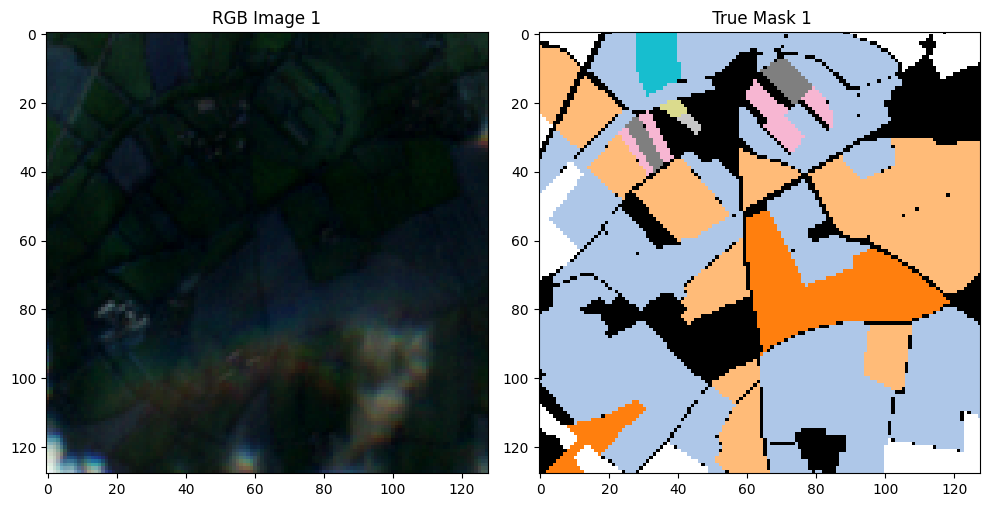

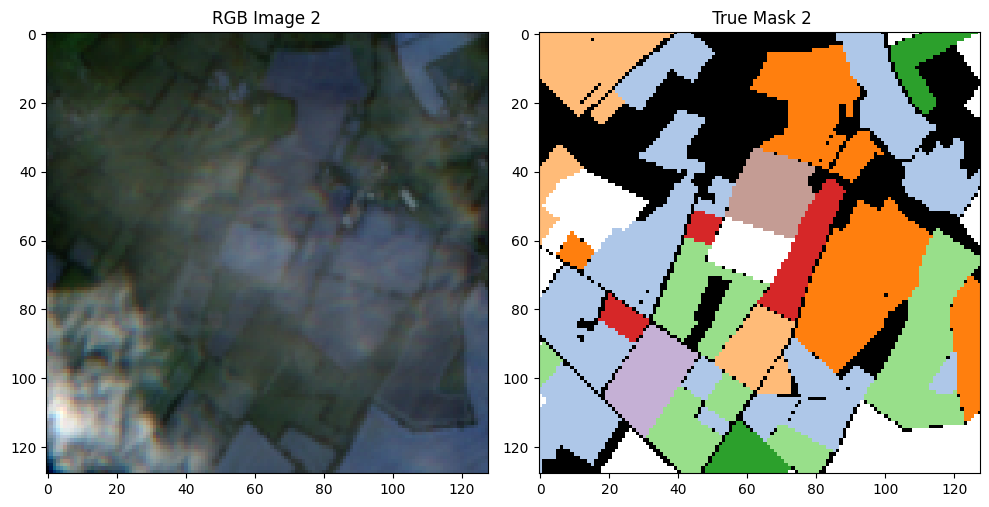

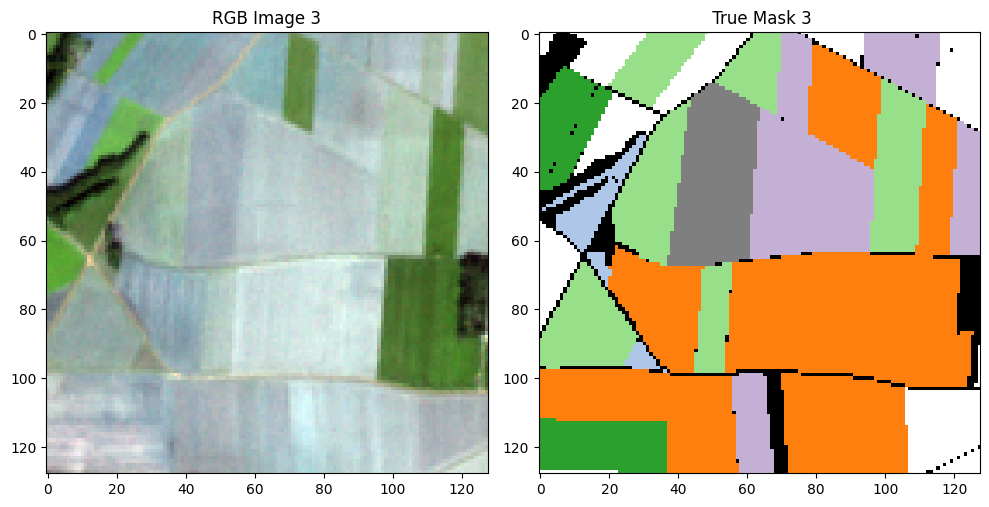

In [184]:
# Check 2: Randomly sample a few image-mask pairs from each dataset and visualize them side-by-side to ensure that the images match their corresponding masks.

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib
import tensorflow as tf

def visualize_samples(dataset, num_samples=5, cmap=None):
    """
    Visualizes 'num_samples' image-mask pairs from the given 'dataset'.
    
    Args:
    - dataset (tf.data.Dataset): The dataset to sample from.
    - num_samples (int): Number of samples to visualize.
    - cmap (ListedColormap, optional): Colormap for mask visualization.
    
    Returns:
    None
    """
    
    # Define the colormap if not provided
    if cmap is None:
        cm = matplotlib.cm.get_cmap('tab20')
        def_colors = cm.colors
        cus_colors = ['k'] + [def_colors[i] for i in range(1,20)] + ['w']
        cmap = ListedColormap(colors=cus_colors, name='agri', N=21)
    
    for i, (images, masks) in enumerate(dataset.take(num_samples)):
        # Assuming your RGB channels are in the first three channels of the image
        rgb_images = images[:, :3, :, :]
        
        # Convert one-hot encoded masks back to class labels for visualization
        mask_labels = tf.argmax(masks, axis=-1)
        
        # Choose the first image and mask in the batch for visualization
        sample_rgb_image = rgb_images[0]
        
        # Transpose the image to match imshow expectations
        sample_rgb_image = tf.transpose(sample_rgb_image, [1, 2, 0])
        
        sample_mask_label = mask_labels[0, 0]
        
        # Visualization
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(sample_rgb_image)
        plt.title(f"RGB Image {i+1}")

        plt.subplot(1, 2, 2)
        plt.imshow(sample_mask_label, cmap=cmap)
        plt.title(f" True Mask {i+1}")
        # Uncomment the next line if you want to show the colorbar
        # plt.colorbar(ticks=np.arange(21), orientation='vertical')
        
        plt.tight_layout()
        plt.show()

# Example usage:
visualize_samples(test_dataset, num_samples=3, cmap=semantic_cmap)


## 2d-Unet for semantic segmentation

### visualise the predicted masks

In [28]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Dropout
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import ListedColormap
import tensorflow_addons as tfa

def unet_segmentation_model(input_shape, num_classes):
    inputs = Input(input_shape)
    
    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    p2 = MaxPooling2D((2, 2))(c2)
    
    # Middle
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    
    # Decoder
    u1 = UpSampling2D((2, 2))(c3)
    concat1 = Concatenate()([u1, c2])
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(concat1)
    
    u2 = UpSampling2D((2, 2))(c4)
    concat2 = Concatenate()([u2, c1])
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(concat2)
    
    # Segmentation output
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c5)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    return model

# net with drop layers added
def unet_segmentation_model_drop(input_shape, num_classes, dropout_rate=0.55):
    inputs = Input(input_shape)
    
    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    d1 = Dropout(dropout_rate)(c1)
    p1 = MaxPooling2D((2, 2))(d1)
    
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    d2 = Dropout(dropout_rate)(c2)
    p2 = MaxPooling2D((2, 2))(d2)
    
    # Middle
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    d3 = Dropout(dropout_rate)(c3)
    
    # Decoder
    u1 = UpSampling2D((2, 2))(d3)
    concat1 = Concatenate()([u1, c2])
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(concat1)
    d4 = Dropout(dropout_rate)(c4)
    
    u2 = UpSampling2D((2, 2))(d4)
    concat2 = Concatenate()([u2, c1])
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(concat2)
    d5 = Dropout(dropout_rate)(c5)
    
    # Segmentation output
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(d5)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    return model




In [ ]:
# Train the model batch-wise

def flatten_masks_channelwise(masks):
    return tf.reduce_mean(masks, axis=3)  # averaging along the channel dimension


def train_model_batchwise(train_dataset, validation_dataset, model, max_batches=None, epochs=1):
    history = {
        'loss': [],
        'val_loss': [],
    }
    
    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")
        # Training
        train_losses = []
        batch_count = 0
        for images, masks in train_dataset:
            # Break the loop if max_batches is reached
            if max_batches and batch_count >= max_batches:
                break
            
            # Transpose the dimensions to (batch, height, width, channels)
            images_transposed = tf.transpose(images, [0, 2, 3, 1])
            masks_transposed = tf.transpose(masks, [0, 2, 3, 1, 4])
            masks_flattened = flatten_masks_channelwise(masks_transposed)
            #print('training',masks_flattened.shape)

            # Train the model on this batch
            loss, _ = model.train_on_batch(images_transposed, masks_flattened)
            train_losses.append(loss)
            
            batch_count += 1  # Increment the batch counter
        
        avg_train_loss = np.mean(train_losses)
        history['loss'].append(avg_train_loss)
        
        # Validation
        val_losses = []
        batch_count = 0
        for images, masks in validation_dataset:
            if max_batches and batch_count >= max_batches:
                break

            images_transposed = tf.transpose(images, [0, 2, 3, 1])
            masks_transposed = tf.transpose(masks, [0, 2, 3, 1, 4])
            masks_flattened = flatten_masks_channelwise(masks_transposed)
            #print('validating',masks_flattened.shape)
            
            # Validate the model on this batch
            val_loss, _ = model.evaluate(images_transposed, masks_flattened, verbose=0)
            val_losses.append(val_loss)
            
            batch_count += 1
        
        avg_val_loss = np.mean(val_losses)
        history['val_loss'].append(avg_val_loss)
        
        print(f"Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

    return history

# Create and compile the model
input_shape = (128, 128, 10)
num_classes = 20
model = unet_segmentation_model(input_shape, num_classes)

optimizer = tfa.optimizers.RectifiedAdam(
    learning_rate=0.005,
    warmup_proportion=0.3,
    min_lr=0.0001
)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=[tf.keras.metrics.MeanIoU(num_classes=num_classes)])

# Train the model
history = train_model_batchwise(train_dataset, validation_dataset, model, max_batches=30, epochs=25)



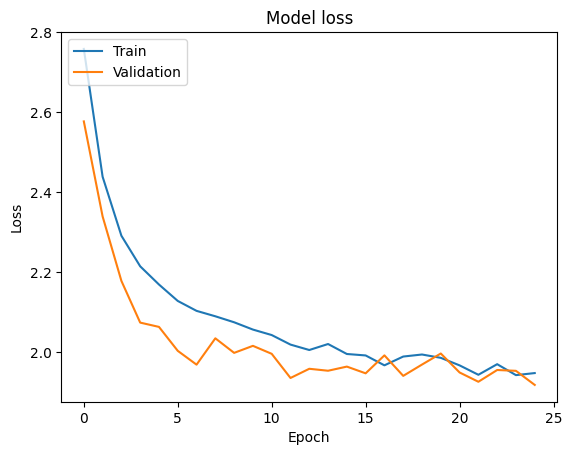

In [25]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Evaluate model on test set
test_losses = []
test_ious = []
for images, masks in test_dataset:

    images_transposed = tf.transpose(images, [0, 2, 3, 1])
    masks_transposed = tf.transpose(masks, [0, 2, 3, 1, 4])
    masks_flattened = flatten_masks_channelwise(masks_transposed)
    #print('testing',masks_flattened.shape)
    
    loss, iou = model.evaluate(images_transposed,  masks_flattened, verbose=0)
    test_losses.append(loss)
    test_ious.append(iou)

    # Get predictions
    pred_masks = model.predict(images_transposed)


    # Plot the results for the first few samples in the batch
    plot_results(images_transposed.numpy(), masks_flattened.numpy(), pred_masks, num_samples=1)  # Adjust num_samples as needed
    


avg_test_loss = np.mean(test_losses)
avg_test_iou = np.mean(test_ious)
print(f"Test Loss: {avg_test_loss:.4f}, Test MeanIoU: {avg_test_iou:.4f}")

In [15]:
def plot_results(images, true_masks, pred_masks, num_samples=3, cmap=None):
    """
    Visualizes 'num_samples' image-mask pairs and predicted masks.
    
    Args:
    - images (tensor or np.array): Array of images of shape (batch, height, width, channels).
    - true_masks (tensor or np.array): Array of ground truth masks.
    - pred_masks (tensor or np.array): Array of predicted masks from the model.
    - num_samples (int): Number of samples to visualize.
    - cmap (ListedColormap, optional): Colormap for mask visualization.
    
    Returns:
    None
    """
    
    # Define the colormap if not provided
    if cmap is None:
        cm = matplotlib.cm.get_cmap('tab20')
        def_colors = cm.colors
        cus_colors = ['k'] + [def_colors[i] for i in range(1,20)] + ['w']
        cmap = ListedColormap(colors=cus_colors, name='agri', N=21)
    
    for i in range(min(num_samples, len(images))):
        sample_rgb_image = images[i, ..., :3]
        sample_mask_label = tf.argmax(true_masks[i], axis=-1)
        pred_mask_label = tf.argmax(pred_masks[i], axis=-1)
        
        # Visualization
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(sample_rgb_image)
        plt.title(f"RGB Image {i+1}")

        plt.subplot(1, 3, 2)
        plt.imshow(sample_mask_label, cmap=cmap)
        plt.title(f"True Mask {i+1}")

        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask_label, cmap=cmap)
        plt.title(f"Predicted Mask {i+1}")
        
        plt.tight_layout()
        plt.show()
